In [13]:
import numpy as np
from ccfj import GetStationPairs
import os
import matplotlib.pyplot as plt
import scipy.signal as sgn
import scipy.io as scio
import h5py
import yaml

In [14]:
import sys
sys.path.append(r'../tools_F-J/')
from toollib_standard import maplib
from toollib_standard import mathlib
from toollib_standard import filelib
from toollib_standard import stacklib
from toollib_standard import plotlib

In [15]:
with open('a-project_repar.yml', 'r', encoding='utf-8') as f:
    proj = yaml.load(f.read(), Loader=yaml.FullLoader)
name_project = proj['name']
#name_project = 'project_repartrition/repartrition_01-03/'               # Harmon server
name_project

'project_repartition_v3.0/output_repar_01-02/'

In [16]:
with open('0_config.yml', 'r', encoding='utf-8') as f:
    dir_config = yaml.load(f.read(), Loader=yaml.FullLoader)
dir_project_workspace = dir_config['dir_project_workspace']
dir_CC_workspace = dir_config['dir_CC_workspace']
print('dir_CC_workspace: ', dir_CC_workspace)
print('dir_project_workspace: ', dir_project_workspace)
dir_project = os.path.join(dir_project_workspace, name_project)
print('dir_project: ', dir_project)

dir_CC_workspace:  /shdisk/rem2/Harmon/F-J/San/
dir_project_workspace:  /shdisk/rem2/Harmon/F-J/San/
dir_project:  /shdisk/rem2/Harmon/F-J/San/project_repartition_v3.0/output_repar_01-02/


In [17]:
filename = dir_project+'Basic_info.yml'
with open(filename, 'r', encoding='utf-8') as f:
    info_basic = yaml.load(f.read(), Loader=yaml.FullLoader)
filename_bi = dir_project+'Basic_info.npy'
info_basic_bi = np.load(filename_bi, allow_pickle='TRUE').item()      # setting dictionary

In [18]:
key_subworks = info_basic['key_subworks']
key_subworks

['07-03--1',
 '09-03--2',
 '10-03--3',
 '11-03--4',
 '12-03--5',
 '13-03--6',
 '15-03--7',
 '16-03--8',
 '17-03--9',
 '18-03--10',
 '19-03--11',
 '20-03--12',
 '21-03--13',
 '22-03--14',
 '23-03--15',
 '24-03--16',
 '26-03--17',
 '27-03--18',
 '28-03--19',
 '29-03--20',
 '30-03--21',
 '31-03--22',
 '32-03--23',
 '34-03--24',
 '35-03--25',
 '36-03--26',
 '37-03--27',
 '38-03--28',
 '39-03--29',
 '40-03--30',
 '41-03--31',
 '43-03--32',
 '45-03--33',
 '46-03--34',
 '47-03--35',
 '48-03--36',
 '49-03--37',
 '52-03--38',
 '53-03--39',
 '54-03--40',
 '07-04--41',
 '08-04--42',
 '09-04--43',
 '10-04--44',
 '11-04--45',
 '12-04--46',
 '14-04--47',
 '15-04--48',
 '16-04--49',
 '18-04--50',
 '19-04--51',
 '20-04--52',
 '21-04--53',
 '22-04--54',
 '23-04--55',
 '24-04--56',
 '25-04--57',
 '26-04--58',
 '27-04--59',
 '28-04--60',
 '29-04--61',
 '30-04--62',
 '31-04--63',
 '32-04--64',
 '33-04--65',
 '34-04--66',
 '35-04--67',
 '36-04--68',
 '37-04--69',
 '38-04--70',
 '39-04--71',
 '41-04--72',
 

In [19]:
dir_image = dir_project+info_basic['dir_image']
dir_stack = dir_project+info_basic['dir_stack']

In [20]:
def check_timewindow(info_basic,info_basic_bi,key_subwork,v_min,v_max,tao,ax,start,interval,flag_time,flag_sig,flag_plot):
    global dir_stack
    outname = str(key_subwork)+'_gather_linear.h5'
    ncffile = h5py.File(dir_stack + outname,'r')
    ncfs_sum_linear = ncffile['ncfs'][:]
    r0 = ncffile['r'][:]

    indx = np.argsort(r0)
    r0 = r0[indx]
    ncfs_sum_linear = ncfs_sum_linear[indx,:]
    ncfst_linear = mathlib.freq_time(ncfs_sum_linear)


    # half side
    num = int((len(ncfst_linear[0]))/2)
    ncfst_half = np.zeros([np.shape(ncfs_sum_linear)[0],num])
    for i in range(len(ncfst_half)):
        ncfst_half[i,:] = (ncfst_linear[i,0:num][::-1] + ncfst_linear[i,num::])/2
    t = info_basic_bi['t']
    f = info_basic_bi['f']
    #nsta = info_basic['nstaS'][key_subwork]
    nPairs = len(ncfst_half)
    sigwins0,noisewins10,noisewins20 = stacklib.cal_wins(ncfst_half,r0,t[num:],f,v_min,v_max,tao,nPairs,flag_sig)

    info_basic_bi['v_min'][key_subwork] = v_min
    info_basic_bi['v_max'][key_subwork] = v_max
    info_basic_bi['tao'][key_subwork] = tao
    #info_basic_bi['start'][key_subwork] = start
    #info_basic_bi['interval'][key_subwork] = interval
    #info_basic_bi['flag_time'][key_subwork] = flag_time
    info_basic_bi['sigwins'][key_subwork] = sigwins0
    info_basic_bi['noisewins1'][key_subwork] = noisewins10
    info_basic_bi['noisewins2'][key_subwork] = noisewins20

    # plot
    if flag_plot == 0:
        return t,ncfst_linear,info_basic_bi
    
    title0 = ' '
    #title0 = 'CCF in time domain for subwork: ' + key_subwork
    xlim = [-1,1]
    ax[0] = plotlib.plot_ncfst(ax[0],t,ncfst_linear[start::interval],r0[start::interval],title0,flag_time,xlim,0)
    ax[1] = plotlib.plot_ncfst(ax[1],t,ncfst_linear[start::interval],r0[start::interval],title0,flag_time,xlim,0)
    r = r0[start::interval]
    sigwins = sigwins0[start::interval]
    noisewins1 = noisewins10[start::interval]
    noisewins2 = noisewins20[start::interval]
    for i in range(len(r)):
        ax[1].plot(t[num+sigwins[i][0]],r[i],'r.')
        ax[1].plot(t[num+sigwins[i][1]],r[i],'r.')
        ax[1].plot(-t[num+sigwins[i][0]],r[i],'r.')
        ax[1].plot(-t[num+sigwins[i][1]],r[i],'r.')
        ax[1].hlines(r[i],t[num+sigwins[i][0]],t[num+sigwins[i][1]],'g',linestyles='--')
        ax[1].hlines(r[i],-t[num+sigwins[i][0]],-t[num+sigwins[i][1]],'g',linestyles='--')
    #title0 = 'CCF in time domain for subwork: ' + key_subwork
    #xlim = [0,300]
    #ax[1] = plotlib.plot_ncfst_timewindow(ax[1],t[num:],ncfst_half[start::interval],r0[start::interval],title0,flag_time,v,tao,xlim)
    plt.tight_layout()
    dir_image = dir_project + info_basic['dir_image']
    #plt.savefig(dir_image+key_subwork+'_CCF-timewindow.png',dpi=60)
    #plt.savefig(dir_project+'image/CCF_timewindow_'+key_subwork+'.png',dpi=300)

    
    return t,ncfst_linear,info_basic_bi

In [21]:
info_basic_bi['v_min'] = {}
info_basic_bi['v_max'] = {}
info_basic_bi['tao'] = {}
#info_basic_bi['start'] = {}
#info_basic_bi['interval'] = {}
#info_basic_bi['flag_time'] = {}
info_basic_bi['sigwins'] = {}
info_basic_bi['noisewins1'] = {}
info_basic_bi['noisewins2'] = {}

In [22]:
flag_time = 0.02
start = 0
interval = 10
info_basic['flag_time'] = flag_time
info_basic['start'] = start
info_basic['interval'] = interval
with open(dir_project+'Basic_info.yml', 'w', encoding='utf-8') as f:
   yaml.dump(data=info_basic, stream=f, allow_unicode=True)

In [23]:
key_subworks_sample = key_subworks[0:10:5]
key_subworks_sample

['07-03--1', '13-03--6']

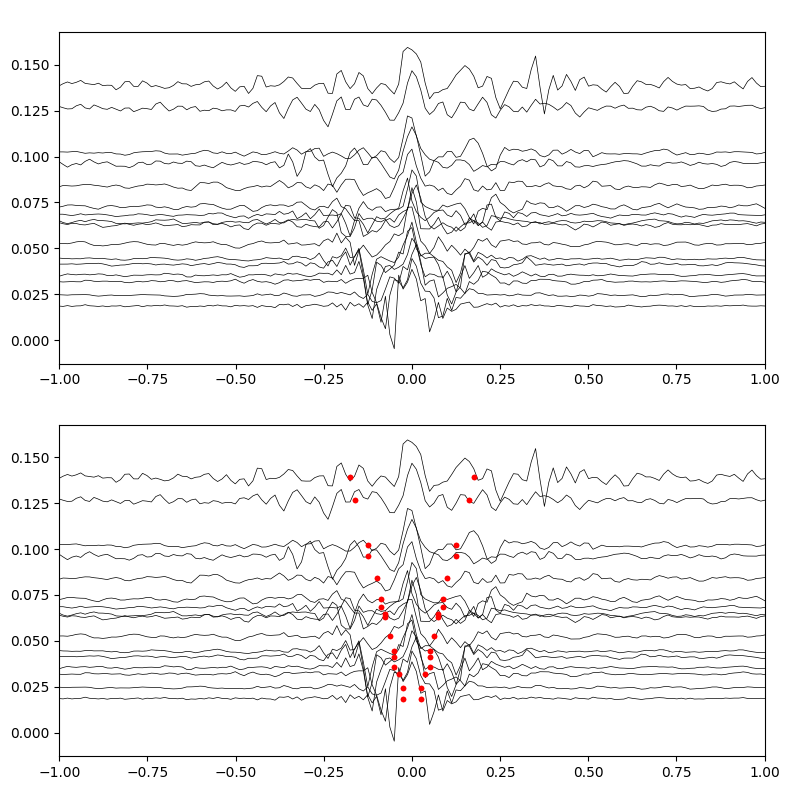

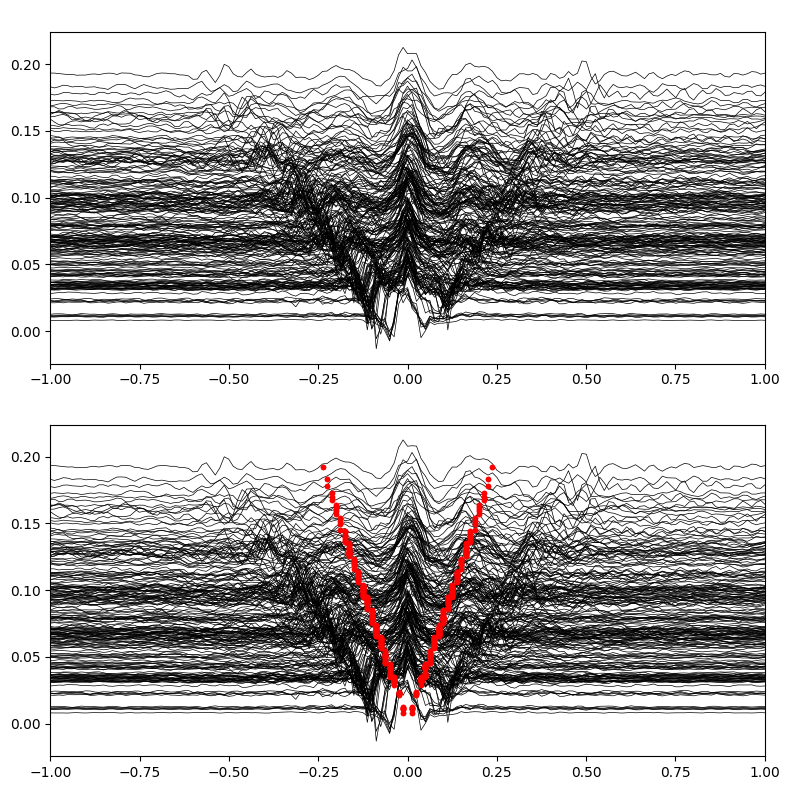

In [24]:
for key_subwork in key_subworks_sample:
    flag_sig = 0
    v_min = 0.8
    v_max = 0.8
    tao = 0.0
    fig,ax = plt.subplots(2,1,figsize = (8,8))
    t,ncfst,info_basic_bi = check_timewindow(info_basic,info_basic_bi,key_subwork,v_min,v_max,tao,ax,start,interval,flag_time,flag_sig,1)